In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [2]:
train = pd.read_csv('../input/fake-news/train.csv')
test = pd.read_csv('../input/fake-news/test.csv')

In [3]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# Data preprocessing and cleaning

In [4]:
train['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


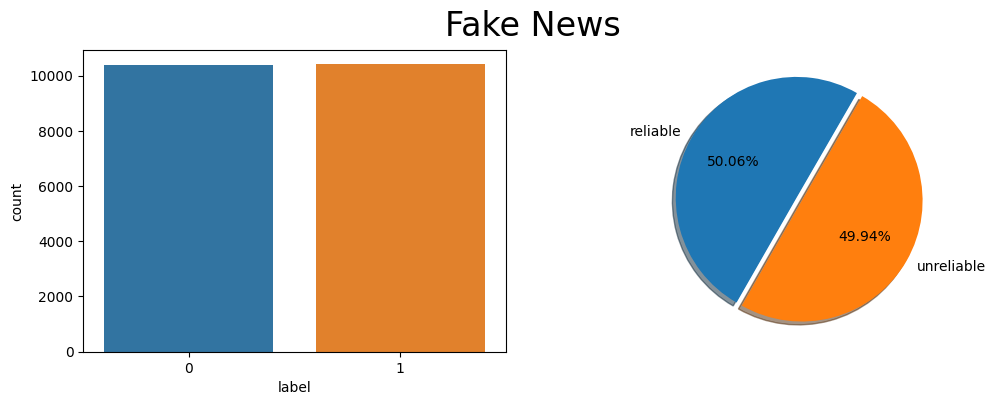

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4), dpi=100)
sns.countplot(train['label'], ax=axes[0])
axes[1].pie(train['label'].value_counts(),
            labels=['reliable', 'unreliable'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Fake News', fontsize=24)
plt.show()

In [6]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

Filling NULL values with empty string


In [8]:
train = train.fillna('')
test=test.fillna('')

We will be only using title and author name for prediction
Creating new coolumn total concatenating title and author


In [9]:
train['total'] = train['title']+' '+train['author']
test['total']=test['title']+' '+test['author']

In [10]:
X = train.drop('label',axis=1)
y=train['label']
print(X.shape)
print(y.shape)

(20800, 5)
(20800,)


Choosing vocabulary size to be 6000 and copying data to msg for further cleaning

In [11]:
voc_size = 6000
msg = X.copy()
msg_test = test.copy()

In [12]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will be using Stemming here
Stemming map words to their root forms

In [13]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []

# Cleaning Text

* Removed urls, emojis and punctuations
* Tokenized base text and title
* Lower cased clean text
* Removed stopwords
* Applying word Stemming
* Converted tokenized text to string again

In [14]:
for i in range(len(msg)):
    review = re.sub('[^a-zA-Z]',' ',msg['total'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [15]:
corpus_test = []
for i in range(len(msg_test)):
    review = re.sub('[^a-zA-Z]',' ',msg_test['total'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_test.append(review)

In [16]:
onehot_rep = [one_hot(words,voc_size)for words in corpus]
onehot_rep_test = [one_hot(words,voc_size)for words in corpus_test]

Padding Sentences to make them of same size

In [17]:
embedded_docs = pad_sequences(onehot_rep,padding='pre',maxlen=25)
embedded_docs_test = pad_sequences(onehot_rep_test,padding='pre',maxlen=25)

# Model Training

In [18]:
#We have used embedding layers with LSTM
model = Sequential()
model.add(Embedding(voc_size,40,input_length=25))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 40)            240000    
_________________________________________________________________
dropout (Dropout)            (None, 25, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

Converting into numpy array

In [19]:
X_final = np.array(embedded_docs)
y_final = np.array(y)
test_final = np.array(embedded_docs_test)
X_final.shape,y_final.shape,test_final.shape

((20800, 25), (20800,), (5200, 25))

In [20]:
history = model.fit(X_final,y_final,epochs=20,batch_size=64)

Epoch 1/20
325/325 [==============================] - 11s 28ms/step - loss: 0.3391 - accuracy: 0.8389
Epoch 2/20
325/325 [==============================] - 9s 29ms/step - loss: 0.0178 - accuracy: 0.9939
Epoch 3/20
325/325 [==============================] - 9s 29ms/step - loss: 0.0069 - accuracy: 0.9983
Epoch 4/20
325/325 [==============================] - 9s 29ms/step - loss: 0.0035 - accuracy: 0.9990
Epoch 5/20
325/325 [==============================] - 9s 28ms/step - loss: 0.0036 - accuracy: 0.9989
Epoch 6/20
325/325 [==============================] - 9s 28ms/step - loss: 0.0011 - accuracy: 0.9996
Epoch 7/20
325/325 [==============================] - 9s 29ms/step - loss: 0.0015 - accuracy: 0.9996
Epoch 8/20
325/325 [==============================] - 9s 28ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 9/20
325/325 [==============================] - 9s 27ms/step - loss: 0.0014 - accuracy: 0.9996
Epoch 10/20
325/325 [==============================] - 9s 28ms/step - loss: 0.0012 - accur

Text(0.5, 0, 'epoch')

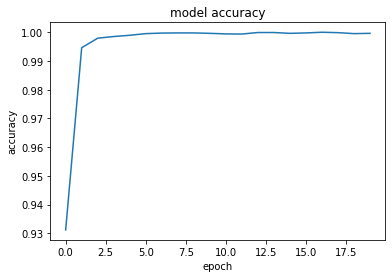

In [21]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [22]:
y_pred = model.predict_classes(test_final)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [23]:
res = pd.DataFrame()
res['id']=test['id']
res['label'] = y_pred
res.to_csv('result.csv',index=False)